In [1]:
import sys
import json
import pandas as pd
import torch as tc
import torch.nn as nn
import torch.optim as optim
from itertools import product
from sklearn.datasets import fetch_california_housing

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from build_dataset import get_dataloaders
from experiment import model_pipeline
from utils import JsonManager, set_seed, load_config
from search_hyperparams import search_hyperparameters
from synthesize_results import load_results
from plots import *

In [3]:
cfg = load_config(path=f"../config.yaml")
print(json.dumps(vars(cfg), indent=2))

set_seed(cfg.seed)
device = "cuda" if tc.cuda.is_available() else "cpu"

{
  "dataset": "housing",
  "fig_path": "../outputs/",
  "seed": 42,
  "dpi": 400,
  "normalize": "StandardScaler",
  "data_split": 0.2,
  "batch_size": 128
}


In [4]:
folder = "../experiments/"
subfolder = "base_model/"
fpath = folder + subfolder

json_manager = JsonManager(folder)
prms = json_manager.load(subfolder + "params.json")
print(json.dumps(vars(prms), indent=4))

{
    "model_version": "baseline",
    "epochs": 15,
    "learning_rate": 0.0001,
    "hidden_dim": 64,
    "dropout": 0.0
}


### Data visualization

In [5]:
df_housing = fetch_california_housing(as_frame=True).frame
print(df_housing.columns)

Index(['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup',
       'Latitude', 'Longitude', 'MedHouseVal'],
      dtype='object')


In [6]:
print(df_housing.head(5).to_markdown(index=False))

|   MedInc |   HouseAge |   AveRooms |   AveBedrms |   Population |   AveOccup |   Latitude |   Longitude |   MedHouseVal |
|---------:|-----------:|-----------:|------------:|-------------:|-----------:|-----------:|------------:|--------------:|
|   8.3252 |         41 |    6.98413 |     1.02381 |          322 |    2.55556 |      37.88 |     -122.23 |         4.526 |
|   8.3014 |         21 |    6.23814 |     0.97188 |         2401 |    2.10984 |      37.86 |     -122.22 |         3.585 |
|   7.2574 |         52 |    8.28814 |     1.07345 |          496 |    2.80226 |      37.85 |     -122.24 |         3.521 |
|   5.6431 |         52 |    5.81735 |     1.07306 |          558 |    2.54795 |      37.85 |     -122.25 |         3.413 |
|   3.8462 |         52 |    6.28185 |     1.08108 |          565 |    2.18147 |      37.85 |     -122.25 |         3.422 |


In [7]:
print(df_housing[["MedInc", "AveBedrms", "AveOccup"]].describe())

             MedInc     AveBedrms      AveOccup
count  20640.000000  20640.000000  20640.000000
mean       3.870671      1.096675      3.070655
std        1.899822      0.473911     10.386050
min        0.499900      0.333333      0.692308
25%        2.563400      1.006079      2.429741
50%        3.534800      1.048780      2.818116
75%        4.743250      1.099526      3.282261
max       15.000100     34.066667   1243.333333


In [8]:
Q1 = df_housing.quantile(0.25)
Q3 = df_housing.quantile(0.75)
IQR = Q3 - Q1

df_housing = df_housing[~((df_housing < (Q1 - 1.5 * IQR)) | (df_housing > (Q3 + 1.5 * IQR))).any(axis=1)]

In [9]:
print(df_housing[["MedInc", "AveBedrms", "AveOccup"]].describe())

             MedInc     AveBedrms      AveOccup
count  16312.000000  16312.000000  16312.000000
mean       3.657930      1.047226      2.865163
std        1.444641      0.066569      0.624931
min        0.536000      0.866013      1.161290
25%        2.561150      1.002732      2.437060
50%        3.494650      1.043733      2.814886
75%        4.583300      1.088686      3.245208
max        8.011300      1.239521      4.560748


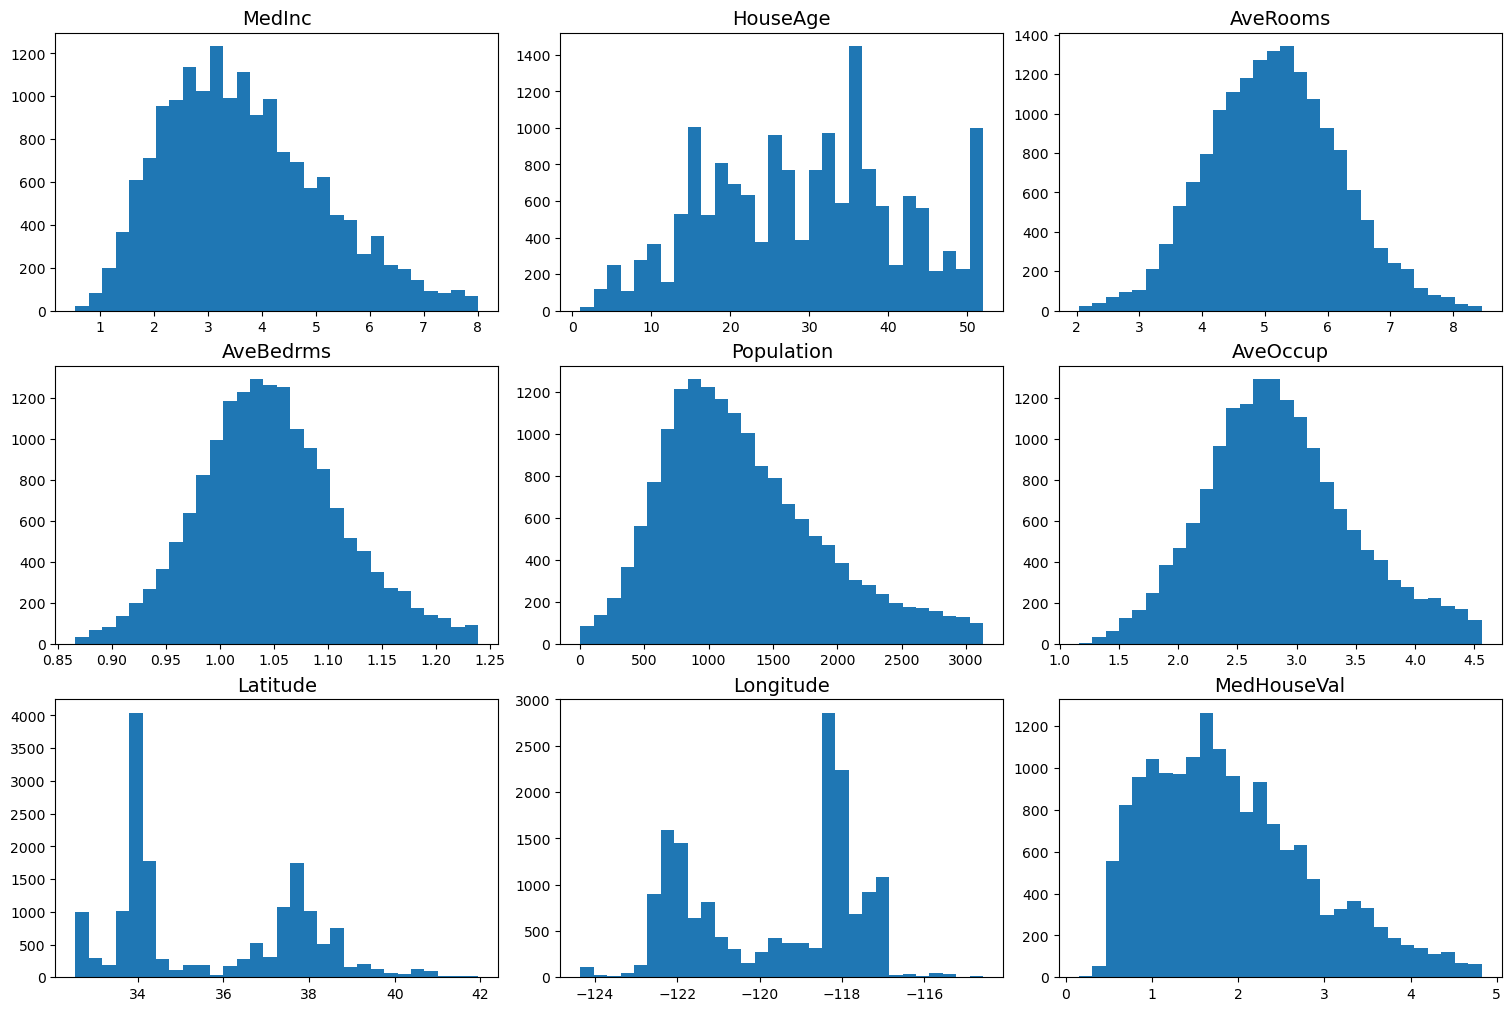

In [10]:
plot_feature_distributions(df_housing, cfg.fig_path, cfg.dpi, cfg.dataset)

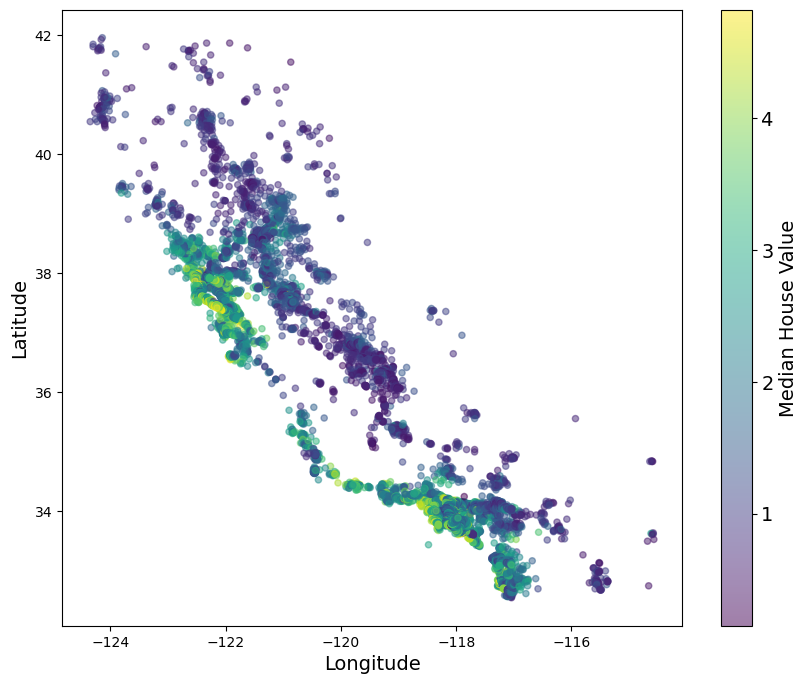

In [11]:
plot_price_by_location(df_housing, cfg.fig_path, cfg.dpi, cfg.dataset)

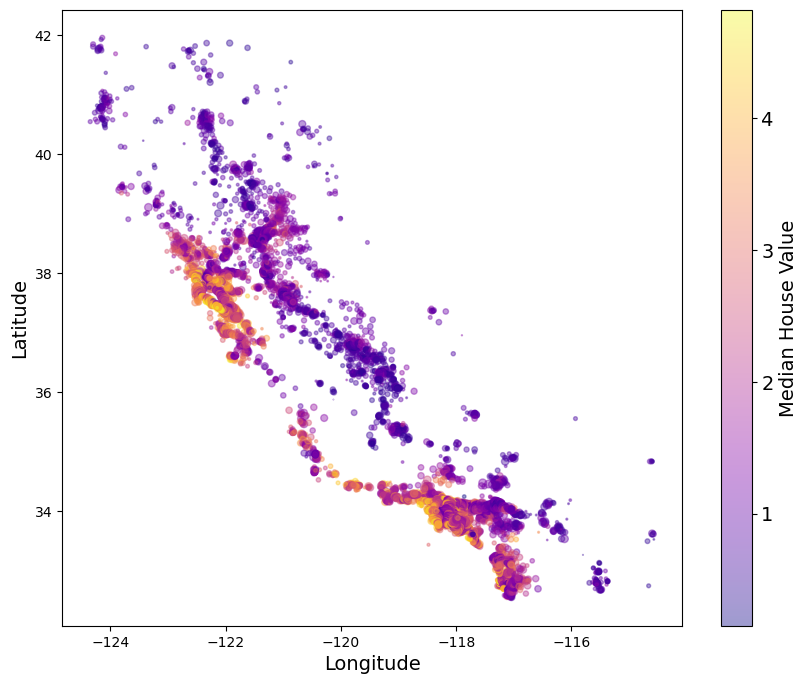

In [12]:
plot_population_and_prices(df_housing, cfg.fig_path, cfg.dpi, cfg.dataset)

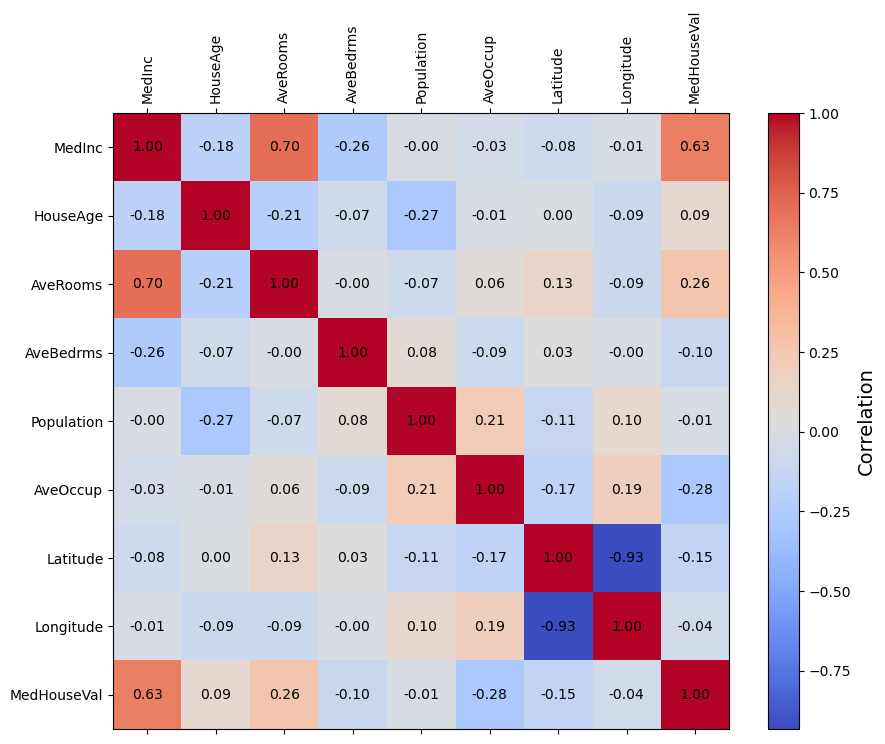

In [13]:
plot_correlation_map(df_housing, cfg.fig_path, cfg.dpi, cfg.dataset)

## Training

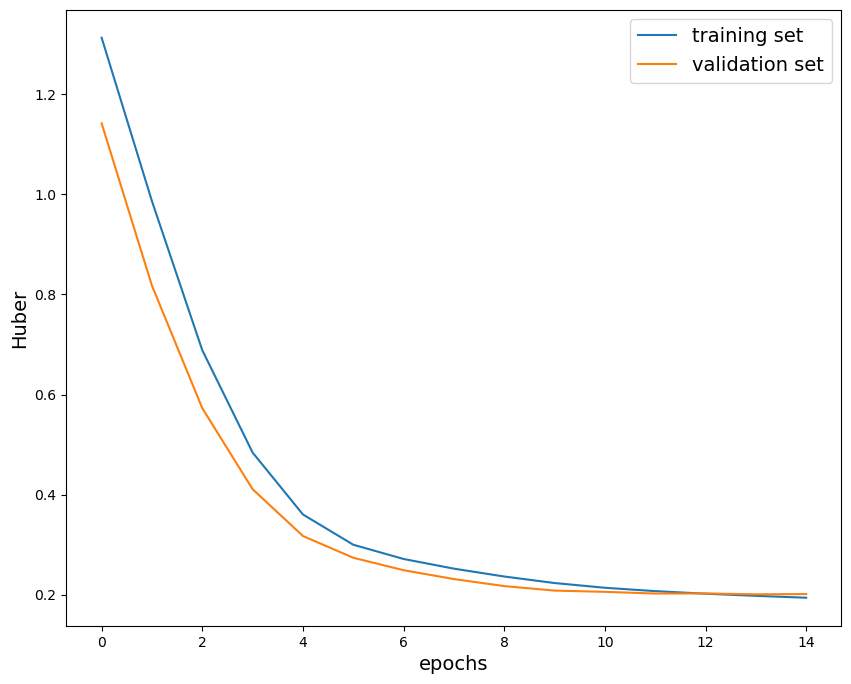

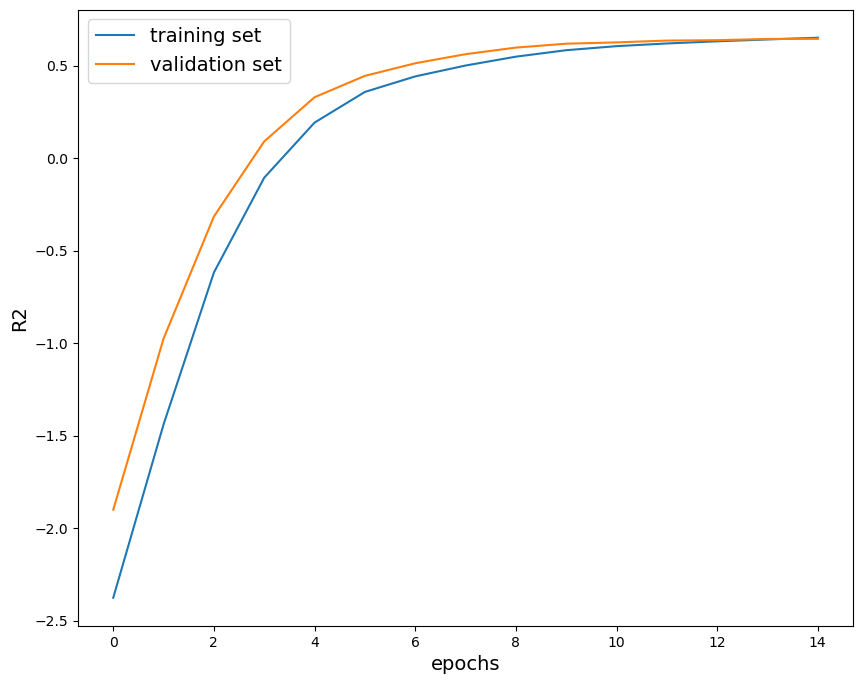

In [14]:
test_metrics = model_pipeline(prms, cfg, fpath, device, show=False, plot=True)

params #1: (0.01, 32, 0.0)


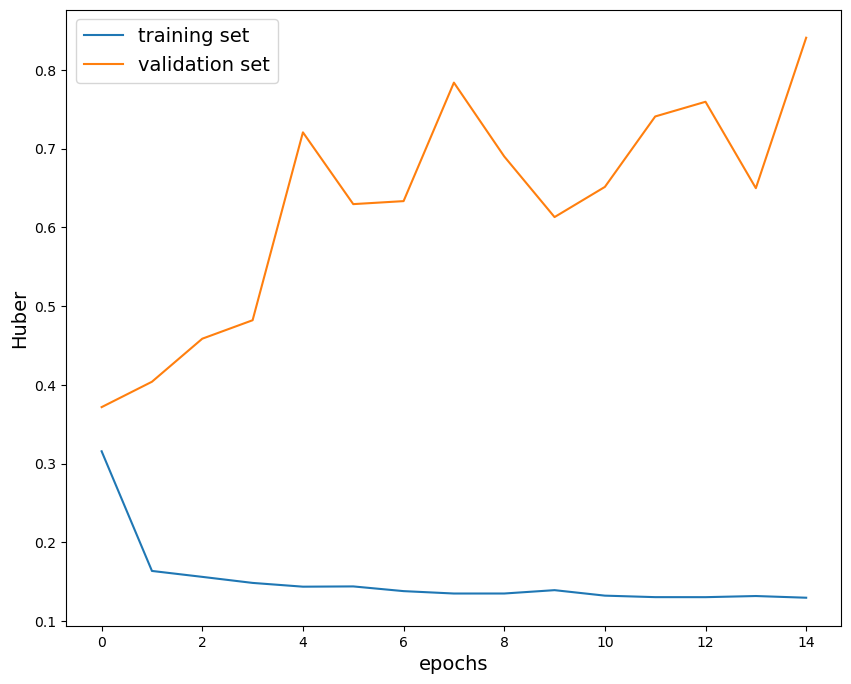

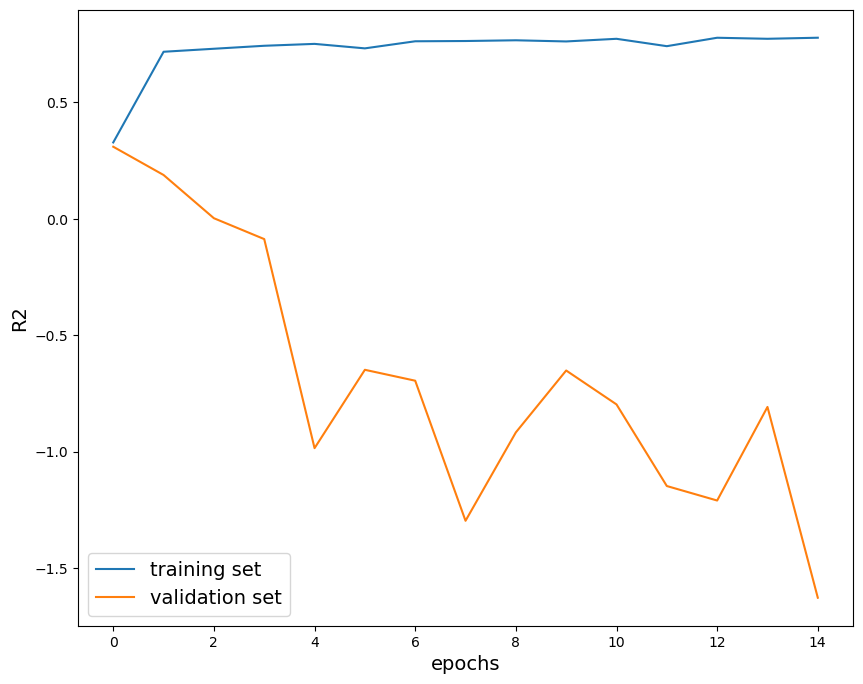

params #2: (0.01, 32, 0.3)


In [ ]:
%%time

vary_lr = [0.01, 0.001, 0.0001]
vary_hidden_dim = [32, 64, 128]
vary_dropout = [0.0, 0.3, 0.6]

prms_product = list(product(vary_lr, vary_hidden_dim, vary_dropout))
test_metrics_vary = search_hyperparameters(prms_product, cfg, folder, json_manager, device, plot=True)

In [ ]:
headers = ["Model", "Validation loss", "Test loss", "Test R2-score"]

metrics = tc.vstack((test_metrics, test_metrics_vary))
load_results("checkpoints", folder, headers, metrics[:, 0], metrics[:, 1])